# make figure summarizing phytoplankton changes

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
#from collections import OrderedDict
import xarray as xr
import numpy as np
#import dask
#from ncar_jobqueue import NCARCluster
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
import matplotlib.path as mpath
#style.use('ggplot')
import utils

### Get the CESM-LE variables (annual means calculated in cesm-le-annual-means-v2.ipynb)

In [2]:
%%time
path = '/glade/scratch/kristenk/CESM-LE-output/CESM-LE-'
variables = ['diatC_zint100m','spC_zint100m','zooC_zint100m',
             'spNPP_zint100m','diatNPP_zint100m','NPP_zint100m','zoo_prod_zint100m',
             'TEMP_100m_mean','SHF_QSW','Fe_avg_100m','phys_med_Fe']

ds_list = []
ds = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}{v}_DJFmean.nc'))  

    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

diatC_zint100m
spC_zint100m
zooC_zint100m
spNPP_zint100m
diatNPP_zint100m
NPP_zint100m
zoo_prod_zint100m
TEMP_100m_mean
SHF_QSW
Fe_avg_100m
phys_med_Fe
CPU times: user 749 ms, sys: 55.1 ms, total: 804 ms
Wall time: 3.63 s


In [3]:
ds['mesozooC'] = ds.zooC_zint100m * (ds.diatC_zint100m/(ds.diatC_zint100m + ds.spC_zint100m))
ds['diat_frac'] = ds.diatC_zint100m/(ds.diatC_zint100m + ds.spC_zint100m)

ds['mesozooC_prod'] = ds.zoo_prod_zint100m * (ds.diatC_zint100m/(ds.diatC_zint100m + ds.spC_zint100m))
ds['diat_frac_NPP'] = ds.diatNPP_zint100m/(ds.diatNPP_zint100m + ds.spNPP_zint100m)

ds['phytoC_zint'] = ds.spC_zint100m + ds.diatC_zint100m

ds['PAR_surf'] = ds.SHF_QSW * 0.45

In [4]:
variables = variables + ['mesozooC','diat_frac','mesozooC_prod','diat_frac_NPP',
             'phytoC_zint','PAR_surf']

### get pop grid

In [5]:
grid = pop_tools.get_grid('POP_gx1v6')

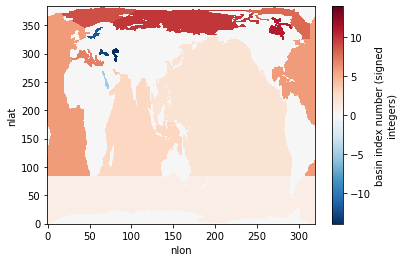

In [6]:
grid.REGION_MASK.plot()

In [7]:
lons = grid.TLONG
lats = grid.TLAT
years = ds.time.values
years

array([1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931,
       1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942,
       1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953,
       1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964,
       1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975,
       1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986,
       1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997,
       1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
       2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
       2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030,
       2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041,
       2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052,
       2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063,
       2064, 2065, 2066, 2067, 2068, 2069, 2070, 20

### mask out nans in ds

In [8]:
ds = ds.where(grid.REGION_MASK>0)

### convert rate vars

In [9]:
### convert production from mmol/m3 cm/sec to gC/m2/y
ds['zoo_prod_zint100m'] = ds.zoo_prod_zint100m * 0.01 * 86400. * 365. * 0.001 * 12.
ds.zoo_prod_zint100m.attrs['units'] = 'gC m-2 y-1'

ds['mesozooC_prod'] = ds.mesozooC_prod * 0.01 * 86400. * 365. * 0.001 * 12.
ds.mesozooC_prod.attrs['units'] = 'gC m-2 y-1'

ds['NPP_zint100m'] = ds.NPP_zint100m * 0.01 * 86400. * 365. * 0.001 * 12.
ds.NPP_zint100m.attrs['units'] = 'gC m-2 y-1'

ds['diatNPP_zint100m'] = ds.diatNPP_zint100m * 0.01 * 86400. * 365. * 0.001 * 12.
ds.diatNPP_zint100m.attrs['units'] = 'gC m-2 y-1'

ds['spNPP_zint100m'] = ds.spNPP_zint100m * 0.01 * 86400. * 365. * 0.001 * 12.
ds.spNPP_zint100m.attrs['units'] = 'gC m-2 y-1'

### Calculate temperature scaling for TL3 productivity

In [10]:
## create Ft grid (180 timeslices since this is DJF means)
Ft = np.full((34, 180, 384, 320), 1, dtype=float)
Ft = xr.DataArray(Ft)
Ft=Ft.rename({'dim_0':'member_id',
              'dim_1':'time',
              'dim_2':'nlat',
              'dim_3':'nlon'})

Ft_cold = Ft.where(ds.TEMP_100m_mean < 20.)
Ft_warm =  Ft.where(ds.TEMP_100m_mean >= 20.) * 0.74

#now convert everything to numpy arrays so we can merge the two grids
Ft = np.asarray(Ft)
Ft_cold = np.asarray(Ft_cold)
Ft_warm = np.asarray(Ft_warm)

Ft[~np.isnan(Ft_cold)] = Ft_cold[~np.isnan(Ft_cold)]
Ft[~np.isnan(Ft_warm)] = Ft_warm[~np.isnan(Ft_warm)]

#now put it back to an xarray
Ft = xr.DataArray(Ft)
Ft=Ft.rename({'dim_0':'member_id',
              'dim_1':'time',
              'dim_2':'nlat',
              'dim_3':'nlon'})

### mask out land
Ft = Ft.where(grid.REGION_MASK>0)

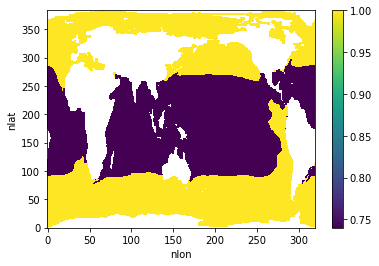

In [11]:
Ft.isel(time=8,member_id=3).plot()

In [12]:
Ft['time'] = ds.time
Ft['member_id'] = ds.member_id

In [13]:
ds.zoo_prod_zint100m

<xarray.DataArray 'zoo_prod_zint100m' (time: 180, member_id: 34, nlat: 384, nlon: 320)>
dask.array<mul, shape=(180, 34, 384, 320), dtype=float64, chunksize=(180, 34, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    TLAT       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG      (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
  * time       (time) int64 1921 1922 1923 1924 1925 ... 2097 2098 2099 2100
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Zooplankton production depth integrated to 100m
    units:         gC m-2 y-1
    grid_loc:      3114
    cell_methods:  time: mean

In [14]:
#trophic level 3
L = 3
alpha = 0.14
E = 0.14

ds['TL3_prod'] = alpha * ds['mesozooC_prod'] * (Ft * E)**(L-2.1) #answer will be in gC/m2/y
ds.TL3_prod.attrs = ds.zoo_prod_zint100m.attrs
ds.TL3_prod.attrs['long_name'] = 'trophic level 3 production'

In [15]:
variables = variables + ['TL3_prod']

### extract 1920s

In [16]:
ds.time.isel(time=slice(0,10)).values

array([1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930])

In [17]:
ds_1920s = ds.isel(time=slice(0,10)).mean(dim='time')

### extract 1990s

In [18]:
ds.time.isel(time=slice(70,80)).values

array([1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000])

In [19]:
ds_1990s = ds.isel(time=slice(70,80)).mean(dim='time')

### Extract 2090s

In [20]:
ds.time.isel(time=slice(-11,-1)).values

array([2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099])

In [21]:
ds_2090s = ds.isel(time=slice(-11,-1)).mean(dim='time')

In [22]:
ensemble_mean_1920s = ds_1920s.mean(dim='member_id')
ensemble_mean_1990s = ds_1990s.mean(dim='member_id')
ensemble_mean_2090s = ds_2090s.mean(dim='member_id')

### Read in masks

In [23]:
file = '/glade/work/kristenk/TTE_CESM-LE/masks_1990s_v3.nc'
ds_masks = xr.open_dataset(file,decode_times=False)
ds_masks

<xarray.Dataset>
Dimensions:            (nlat: 384, nlon: 320)
Coordinates:
    TLAT               (nlat, nlon) float64 ...
    TLONG              (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon
Data variables:
    ACC_mask           (nlat, nlon) float64 ...
    SIZ_mask           (nlat, nlon) float64 ...
    marginal_SIZ_mask  (nlat, nlon) float64 ...

In [24]:
outside=np.full((384, 320), 2)

inside = ds_masks.ACC_mask.where(ds_masks.ACC_mask ==1)
inside = np.asarray(inside)

outside[~np.isnan(inside)] = inside[~np.isnan(inside)]

ACC=xr.DataArray(outside)
ACC=ACC.rename({'dim_0':'nlat'})
ACC=ACC.rename({'dim_1':'nlon'})
ACC = ACC.where(grid.REGION_MASK>0)
#ACC.plot()

In [25]:
outside=np.full((384, 320), 2)

inside = ds_masks.SIZ_mask.where(ds_masks.SIZ_mask ==1)
inside = np.asarray(inside)

outside[~np.isnan(inside)] = inside[~np.isnan(inside)]

SIZ=xr.DataArray(outside)
SIZ=SIZ.rename({'dim_0':'nlat'})
SIZ=SIZ.rename({'dim_1':'nlon'})
SIZ = SIZ.where(grid.REGION_MASK>0)
#SIZ.plot()

In [26]:
%%time
ACC_1920s_ds = xr.Dataset()
ACC_2090s_ds = xr.Dataset()
SIZ_1920s_ds = xr.Dataset()
SIZ_2090s_ds = xr.Dataset()

for v in variables:
    print(v)

    masked = ensemble_mean_1920s[v].where(ACC==1)
    ACC_1920s_ds[v] = esmlab.statistics.weighted_mean(masked, weights=grid.TAREA, dim=['nlat', 'nlon']).compute()

    masked = ensemble_mean_2090s[v].where(ACC==1)
    ACC_2090s_ds[v] = esmlab.statistics.weighted_mean(masked, weights=grid.TAREA, dim=['nlat', 'nlon']).compute()
    
    masked = ensemble_mean_1920s[v].where(SIZ==1)
    SIZ_1920s_ds[v] = esmlab.statistics.weighted_mean(masked, weights=grid.TAREA, dim=['nlat', 'nlon']).compute()

    masked = ensemble_mean_2090s[v].where(SIZ==1)
    SIZ_2090s_ds[v] = esmlab.statistics.weighted_mean(masked, weights=grid.TAREA, dim=['nlat', 'nlon']).compute()
    

diatC_zint100m
spC_zint100m
zooC_zint100m
spNPP_zint100m
diatNPP_zint100m
NPP_zint100m
zoo_prod_zint100m
TEMP_100m_mean
SHF_QSW
Fe_avg_100m
phys_med_Fe
mesozooC
diat_frac
mesozooC_prod
diat_frac_NPP
phytoC_zint
PAR_surf
TL3_prod
CPU times: user 4min 23s, sys: 9min 40s, total: 14min 4s
Wall time: 18min 5s


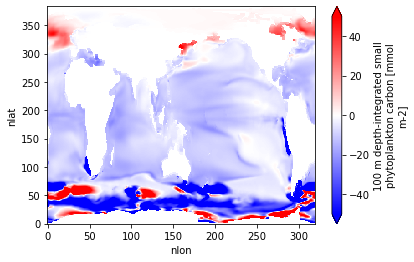

In [27]:
diff_phytobiomass = ensemble_mean_2090s.phytoC_zint- ensemble_mean_1920s.phytoC_zint
diff_phytobiomass.plot(vmin=-50,vmax=50,cmap='bwr')

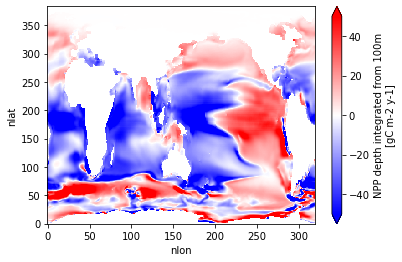

In [28]:
diff_NPP = ensemble_mean_2090s.NPP_zint100m - ensemble_mean_1920s.NPP_zint100m
diff_NPP.plot(vmin=-50,vmax=50,cmap='bwr')

### Figures

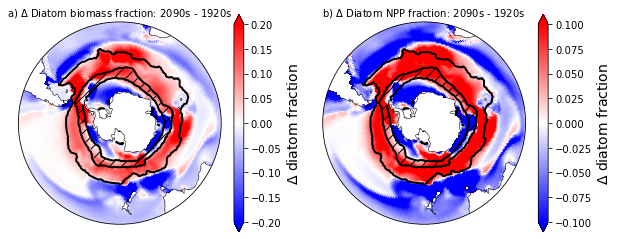

In [29]:
fig = plt.figure(figsize=(10,4))

ax = fig.add_subplot(1,2,1, projection=ccrs.SouthPolarStereo())
ax.set_title('a) ${\Delta}$ Diatom biomass fraction: 2090s - 1920s',fontsize=10)
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

#### plot diat frac
lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.diat_frac- ensemble_mean_1920s.diat_frac))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.2, vmax=0.2, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

############ masks ################################

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)


pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

### ACC
lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)


pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='${\Delta}$ diatom fraction')
cbar1.set_label(label='${\Delta}$ diatom fraction', fontsize=14)

################ diat NPP fraction
ax = fig.add_subplot(1,2,2, projection=ccrs.SouthPolarStereo())
ax.set_title('b) ${\Delta}$ Diatom NPP fraction: 2090s - 1920s',fontsize=10)
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

#### plot diat frac
lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.diat_frac_NPP- ensemble_mean_1920s.diat_frac_NPP))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.1, vmax=0.1, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

############ masks ################################

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)


pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

### ACC
lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)


pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='${\Delta}$ diatom fraction')
cbar1.set_label(label='${\Delta}$ diatom fraction', fontsize=14)


#fig.savefig('/glade/work/kristenk/figs/diatfracchange_withmasks.png', bbox_inches='tight', dpi=300, format='png');

### put maps together for model variables

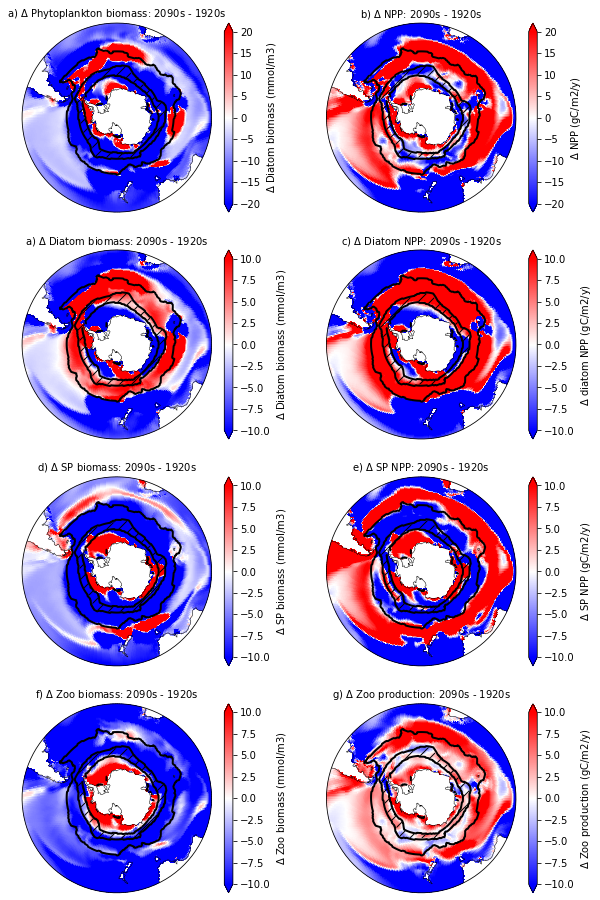

In [30]:
fig = plt.figure(figsize=(10,16))

################ Biomass ################################################
ax = fig.add_subplot(4,2,1, projection=ccrs.SouthPolarStereo())
ax.set_title('a) ${\Delta}$ Phytoplankton biomass: 2090s - 1920s',fontsize=10)
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

#### plot diat frac
lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.phytoC_zint- ensemble_mean_1920s.phytoC_zint))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-20, vmax=20, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='${\Delta}$ Diatom biomass (mmol/m3)')

################ NPP ################################################
ax = fig.add_subplot(4,2,2, projection=ccrs.SouthPolarStereo())
ax.set_title('b) ${\Delta}$ NPP: 2090s - 1920s',fontsize=10)
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

#### plot diat frac
lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.NPP_zint100m- ensemble_mean_1920s.NPP_zint100m))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-20, vmax=20, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='${\Delta}$ NPP (gC/m2/y)')

############################# Diatom biomass #################################

ax = fig.add_subplot(4,2,3, projection=ccrs.SouthPolarStereo())
ax.set_title('a) ${\Delta}$ Diatom biomass: 2090s - 1920s',fontsize=10)
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

#### plot diat frac
lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.diatC_zint100m- ensemble_mean_1920s.diatC_zint100m))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-10, vmax=10, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='${\Delta}$ Diatom biomass (mmol/m3)')

################ diat NPP ###############################################

ax = fig.add_subplot(4,2,4, projection=ccrs.SouthPolarStereo())
ax.set_title('c) ${\Delta}$ Diatom NPP: 2090s - 1920s',fontsize=10)
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

#### plot diat frac
lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.diatNPP_zint100m- ensemble_mean_1920s.diatNPP_zint100m))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-10, vmax=10, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='${\Delta}$ diatom NPP (gC/m2/y)')

############################################# SP biomass ###########################

ax = fig.add_subplot(4,2,5, projection=ccrs.SouthPolarStereo())
ax.set_title('d) ${\Delta}$ SP biomass: 2090s - 1920s',fontsize=10)
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.spC_zint100m- ensemble_mean_1920s.spC_zint100m))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-10, vmax=10, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='${\Delta}$ SP biomass (mmol/m3)')

################ sp NPP ####################################################
ax = fig.add_subplot(4,2,6, projection=ccrs.SouthPolarStereo())
ax.set_title('e) ${\Delta}$ SP NPP: 2090s - 1920s',fontsize=10)
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.spNPP_zint100m- ensemble_mean_1920s.spNPP_zint100m))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-10, vmax=10, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='${\Delta}$ SP NPP (gC/m2/y)')

##################################### zoo biomass ############################
ax = fig.add_subplot(4,2,7, projection=ccrs.SouthPolarStereo())
ax.set_title('f) ${\Delta}$ Zoo biomass: 2090s - 1920s',fontsize=10)
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.zooC_zint100m- ensemble_mean_1920s.zooC_zint100m))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-10, vmax=10, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)


pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='${\Delta}$ Zoo biomass (mmol/m3)')

################ zoo prod #########################################################
ax = fig.add_subplot(4,2,8, projection=ccrs.SouthPolarStereo())
ax.set_title('g) ${\Delta}$ Zoo production: 2090s - 1920s',fontsize=10)
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

#### plot diat frac
lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.zoo_prod_zint100m- ensemble_mean_1920s.zoo_prod_zint100m))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-10, vmax=10, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='${\Delta}$ Zoo production (gC/m2/y)')
#fig.savefig('/glade/work/kristenk/figs/diatfracchange_withmasks.png', bbox_inches='tight', dpi=300, format='png');

### put maps together for derived variables

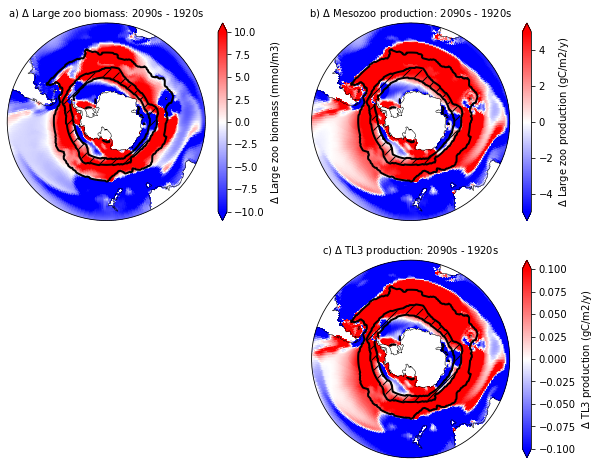

In [31]:
fig = plt.figure(figsize=(10,8))

############################# large zoo biomass ##################################
ax = fig.add_subplot(2,2,1, projection=ccrs.SouthPolarStereo())
ax.set_title('a) ${\Delta}$ Large zoo biomass: 2090s - 1920s',fontsize=10)
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.mesozooC- ensemble_mean_1920s.mesozooC))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-10, vmax=10, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='${\Delta}$ Large zoo biomass (mmol/m3)')

################ large zooplankton production #################################

ax = fig.add_subplot(2,2,2, projection=ccrs.SouthPolarStereo())
ax.set_title('b) ${\Delta}$ Mesozoo production: 2090s - 1920s',fontsize=10)
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.mesozooC_prod- ensemble_mean_1920s.mesozooC_prod))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-5, vmax=5, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='${\Delta}$ Large zoo production (gC/m2/y)')

########################### TL 3 production #########################

ax = fig.add_subplot(2,2,4, projection=ccrs.SouthPolarStereo())
ax.set_title('c) ${\Delta}$ TL3 production: 2090s - 1920s',fontsize=10)
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.TL3_prod- ensemble_mean_1920s.TL3_prod))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.1, vmax=0.1, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='${\Delta}$ TL3 production (gC/m2/y)')

#fig.savefig('/glade/work/kristenk/figs/diatfracchange_withmasks.png', bbox_inches='tight', dpi=300, format='png');

### bar plots of model variables and derived variables

ACC_1920s_ds = xr.Dataset()
ACC_2090s_ds = xr.Dataset()
SIZ_1920s_ds = xr.Dataset()
SIZ_2090s_ds = xr.Dataset()

#### BIOMASS

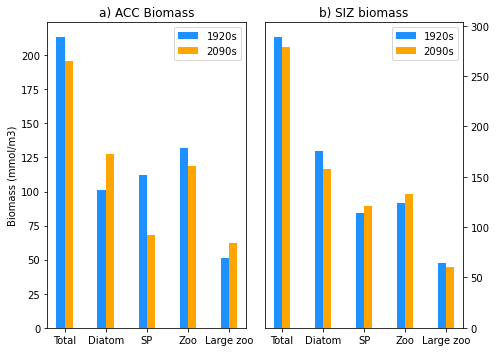

In [32]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(7,5))

# ACC biomass ########################
labels = ['Total','Diatom','SP','Zoo','Large zoo']
xvals = np.arange(len(labels))  # the label locations
width = 0.2 # the width of the bars
#ax[0].set_xlim(-0.5,1.5)
#ax[0].set_ylim(0,150)

vals_1920s = [ACC_1920s_ds.phytoC_zint,ACC_1920s_ds.diatC_zint100m,
              ACC_1920s_ds.spC_zint100m,ACC_1920s_ds.zooC_zint100m,ACC_1920s_ds.mesozooC]
vals_2090s = [ACC_2090s_ds.phytoC_zint,ACC_2090s_ds.diatC_zint100m,
              ACC_2090s_ds.spC_zint100m,ACC_2090s_ds.zooC_zint100m,ACC_2090s_ds.mesozooC]

rects1 = ax[0].bar(xvals - width/2, vals_1920s, width, label='1920s',color='dodgerblue')
rects2 = ax[0].bar(xvals + width/2, vals_2090s, width, label='2090s',color='orange')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax[0].set_ylabel('Biomass (mmol/m3)')
ax[0].set_title('a) ACC Biomass')
ax[0].set_xticks(xvals)
ax[0].set_xticklabels(labels)
ax[0].legend()

# SIZ biomass #############################
labels = ['Total','Diatom','SP','Zoo','Large zoo']
xvals = np.arange(len(labels))  # the label locations
width = 0.2 # the width of the bars
# ax[1].set_xlim(-0.5,1.5)
#ax[1].set_ylim(0,150)

vals_1920s = [SIZ_1920s_ds.phytoC_zint,SIZ_1920s_ds.diatC_zint100m,
              SIZ_1920s_ds.spC_zint100m,SIZ_1920s_ds.zooC_zint100m,SIZ_1920s_ds.mesozooC]
vals_2090s = [SIZ_2090s_ds.phytoC_zint,SIZ_2090s_ds.diatC_zint100m,
              SIZ_2090s_ds.spC_zint100m,SIZ_2090s_ds.zooC_zint100m,SIZ_2090s_ds.mesozooC]

rects1 = ax[1].bar(xvals - width/2, vals_1920s, width, label='1920s',color='dodgerblue')
rects2 = ax[1].bar(xvals + width/2, vals_2090s, width, label='2090s',color='orange')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax[1].set_title('b) SIZ biomass')
ax[1].set_xticks(xvals)
ax[1].set_xticklabels(labels)
ax[1].legend()
#ax[1].axes.yaxis.set_visible(False)
ax[1].yaxis.set_ticks_position("right")

fig.subplots_adjust(wspace=0.05)

fig.tight_layout()

#plt.show()

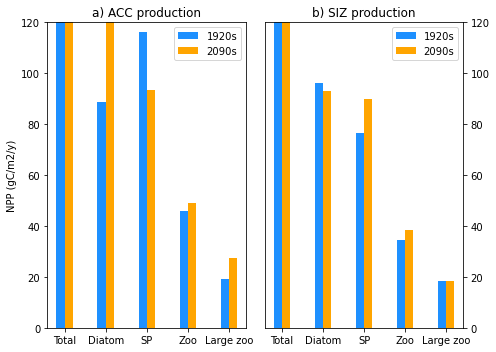

In [33]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(7,5))

# ACC biomass ########################
labels = ['Total','Diatom','SP','Zoo','Large zoo']
xvals = np.arange(len(labels))  # the label locations
width = 0.2 # the width of the bars
#ax[0].set_xlim(-0.5,1.5)
ax[0].set_ylim(0,120)

vals_1920s = [ACC_1920s_ds.NPP_zint100m,ACC_1920s_ds.diatNPP_zint100m,
              ACC_1920s_ds.spNPP_zint100m,ACC_1920s_ds.zoo_prod_zint100m,ACC_1920s_ds.mesozooC_prod]
vals_2090s = [ACC_2090s_ds.NPP_zint100m,ACC_2090s_ds.diatNPP_zint100m,
              ACC_2090s_ds.spNPP_zint100m,ACC_2090s_ds.zoo_prod_zint100m,ACC_2090s_ds.mesozooC_prod]

rects1 = ax[0].bar(xvals - width/2, vals_1920s, width, label='1920s',color='dodgerblue')
rects2 = ax[0].bar(xvals + width/2, vals_2090s, width, label='2090s',color='orange')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax[0].set_ylabel('NPP (gC/m2/y)')
ax[0].set_title('a) ACC production')
ax[0].set_xticks(xvals)
ax[0].set_xticklabels(labels)
ax[0].legend()

# SIZ biomass #############################
labels = ['Total','Diatom','SP','Zoo','Large zoo']
xvals = np.arange(len(labels))  # the label locations
width = 0.2 # the width of the bars
# ax[1].set_xlim(-0.5,1.5)
ax[1].set_ylim(0,120)

vals_1920s = [SIZ_1920s_ds.NPP_zint100m,SIZ_1920s_ds.diatNPP_zint100m,
              SIZ_1920s_ds.spNPP_zint100m,SIZ_1920s_ds.zoo_prod_zint100m,SIZ_1920s_ds.mesozooC_prod]
vals_2090s = [SIZ_2090s_ds.NPP_zint100m,SIZ_2090s_ds.diatNPP_zint100m,
              SIZ_2090s_ds.spNPP_zint100m,SIZ_2090s_ds.zoo_prod_zint100m,SIZ_2090s_ds.mesozooC_prod]

rects1 = ax[1].bar(xvals - width/2, vals_1920s, width, label='1920s',color='dodgerblue')
rects2 = ax[1].bar(xvals + width/2, vals_2090s, width, label='2090s',color='orange')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax[1].set_title('b) SIZ production')
ax[1].set_xticks(xvals)
ax[1].set_xticklabels(labels)
ax[1].legend()
ax[1].yaxis.set_ticks_position("right")


fig.subplots_adjust(wspace=0.05)

fig.tight_layout()

#plt.show()

In [34]:
SIZ_1920s_ds.TEMP_100m_mean

<xarray.DataArray 'TEMP_100m_mean' ()>
array(-1.34685871)
Attributes:
    long_name:     Mean temperature over top 100m
    units:         degC
    grid_loc:      3111
    cell_methods:  time: mean

In [35]:
diff_ACC_ds = ACC_2090s_ds - ACC_1920s_ds

In [36]:
diff_SIZ_ds = SIZ_2090s_ds - SIZ_1920s_ds

In [37]:
frac_change_ACC_ds = diff_ACC_ds / ACC_1920s_ds

In [38]:
frac_change_SIZ_ds = diff_SIZ_ds / SIZ_1920s_ds

In [39]:
frac_change_ACC_ds

<xarray.Dataset>
Dimensions:            ()
Data variables:
    diatC_zint100m     float64 0.2586
    spC_zint100m       float64 -0.3908
    zooC_zint100m      float64 -0.09625
    spNPP_zint100m     float64 -0.1945
    diatNPP_zint100m   float64 0.4273
    NPP_zint100m       float64 0.07459
    zoo_prod_zint100m  float64 0.06795
    TEMP_100m_mean     float64 0.7973
    SHF_QSW            float64 -0.0438
    Fe_avg_100m        float64 0.08797
    phys_med_Fe        float64 0.08557
    mesozooC           float64 0.2139
    diat_frac          float64 0.3242
    mesozooC_prod      float64 0.441
    diat_frac_NPP      float64 0.3384
    phytoC_zint        float64 -0.08309
    PAR_surf           float64 -0.0438
    TL3_prod           float64 0.441

In [42]:
frac_change_SIZ_ds

<xarray.Dataset>
Dimensions:            ()
Data variables:
    diatC_zint100m     float64 -0.1001
    spC_zint100m       float64 0.0657
    zooC_zint100m      float64 0.07695
    spNPP_zint100m     float64 0.1774
    diatNPP_zint100m   float64 -0.0339
    NPP_zint100m       float64 0.0596
    zoo_prod_zint100m  float64 0.1096
    TEMP_100m_mean     float64 -0.8153
    SHF_QSW            float64 0.468
    Fe_avg_100m        float64 -0.1444
    phys_med_Fe        float64 0.7412
    mesozooC           float64 -0.05655
    diat_frac          float64 -0.1278
    mesozooC_prod      float64 -0.01143
    diat_frac_NPP      float64 -0.1391
    phytoC_zint        float64 -0.03483
    PAR_surf           float64 0.468
    TL3_prod           float64 -0.01143

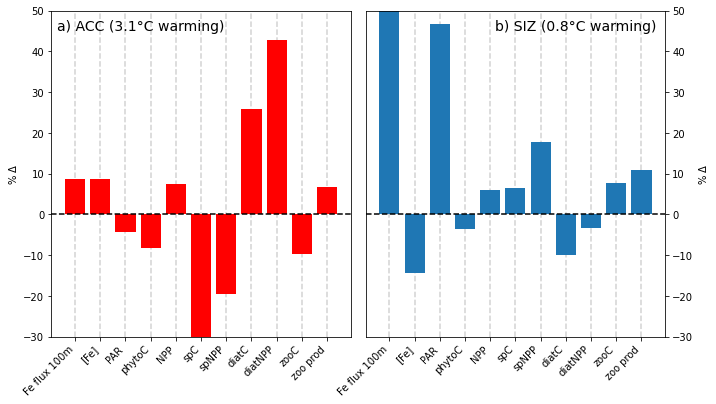

In [40]:
fig = plt.figure(figsize=(11,6))

labels = ['Fe flux 100m','[Fe]','PAR','phytoC','NPP','spC','spNPP','diatC','diatNPP','zooC','zoo prod']
ind = np.arange(0,len(labels))

### ACC
vals = [frac_change_ACC_ds.phys_med_Fe*100.,
       frac_change_ACC_ds.Fe_avg_100m*100.,
       frac_change_ACC_ds.PAR_surf*100., frac_change_ACC_ds.phytoC_zint*100.,
       frac_change_ACC_ds.NPP_zint100m*100., frac_change_ACC_ds.spC_zint100m*100.,
       frac_change_ACC_ds.spNPP_zint100m*100., frac_change_ACC_ds.diatC_zint100m*100.,
       frac_change_ACC_ds.diatNPP_zint100m*100., frac_change_ACC_ds.zooC_zint100m*100.,
       frac_change_ACC_ds.zoo_prod_zint100m*100.]

ax = fig.add_subplot(1,2,1)
ax.bar(ind, vals, color='red')
ax.set_title('a) ACC (3.1°C warming)',fontsize=14,x=0.3,y=0.92)
ax.set_ylabel('% ${\Delta}$')
ax.set_ylim(-30,50)
plt.xticks(ind, labels,rotation=45, ha='right');
ax.axhline(0,linestyle='--',color='black')
for i in ind:
    ax.axvline(ind[i],linestyle='--',color='lightgray',zorder=0)

### SIZ
vals = [frac_change_SIZ_ds.phys_med_Fe*100.,
       frac_change_SIZ_ds.Fe_avg_100m*100.,
       frac_change_SIZ_ds.PAR_surf*100., frac_change_SIZ_ds.phytoC_zint*100.,
       frac_change_SIZ_ds.NPP_zint100m*100., frac_change_SIZ_ds.spC_zint100m*100.,
       frac_change_SIZ_ds.spNPP_zint100m*100., frac_change_SIZ_ds.diatC_zint100m*100.,
       frac_change_SIZ_ds.diatNPP_zint100m*100., frac_change_SIZ_ds.zooC_zint100m*100.,
       frac_change_SIZ_ds.zoo_prod_zint100m*100.]


ax = fig.add_subplot(1,2,2)
ax.bar(ind, vals)
ax.set_title('b) SIZ (0.8°C warming)',fontsize=14,x=0.7,y=0.92)
ax.set_ylabel('% ${\Delta}$')
ax.set_ylim(-30,50)
plt.xticks(ind, labels,rotation=45, ha='right');
ax.axhline(0,linestyle='--',color='black')
ax.yaxis.set_ticks_position("right")
ax.yaxis.set_label_position("right")
for i in ind:
    ax.axvline(ind[i],linestyle='--',color='lightgray',zorder=0)
plt.subplots_adjust(wspace=0.05)

In [41]:
frac_change_SIZ_ds.TEMP_100m_mean*100.

<xarray.DataArray 'TEMP_100m_mean' ()>
array(-81.53141221)
Attributes:
    long_name:     Mean temperature over top 100m
    units:         degC
    grid_loc:      3111
    cell_methods:  time: mean